# Análise Preditiva de Diabetes com Algoritmos de Classificação

## 📋 Sobre o Projeto

O diabetes mellitus afeta milhões de pessoas globalmente. A **detecção precoce** é crucial para prevenir complicações graves e garantir tratamento adequado.

Este notebook desenvolve modelos de Machine Learning para **prever diabetes** usando o [Pima Indians Diabetes Database](https://www.kaggle.com/datasets/uciml/pima-indians-diabetes-database), um dataset clássico do NIDDK com dados de 768 mulheres indígenas Pima.

## 🎯 Objetivos

1. **Pré-processar** dados médicos (tratamento de missings e inconsistências)
2. **Explorar** padrões e correlações nas features clínicas
3. **Comparar** três algoritmos: Logistic Regression, Decision Tree e Random Forest
4. **Priorizar** métricas relevantes para saúde (Recall, AUC-ROC, Acurácia Balanceada)
5. **Minimizar** falsos negativos (risco de não detectar diabetes existente)

## 🔍 Por que este projeto é importante?

Em contextos médicos, **falsos negativos** (dizer que um paciente doente está saudável) são mais críticos que falsos positivos. Por isso, o foco será em **maximizar recall** mantendo boa precisão geral.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

---
# Lendo o Dataset e Visão Geral
---

In [2]:
# =============================================================================
# LEITURA DO DATASET
# =============================================================================
# Para uso local: certifique-se de ter a pasta 'data/' com o arquivo diabetes.csv
# Para uso no Google Colab: descomente as linhas abaixo e ajuste o caminho
# 
# from google.colab import drive
# drive.mount('/content/drive')
# diabetes = pd.read_csv('/content/drive/MyDrive/path/to/diabetes.csv')

# Leitura local
diabetes = pd.read_csv('data/diabetes.csv')
diabetes.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [3]:
diabetes.tail()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1
767,1,93,70,31,0,30.4,0.315,23,0


In [4]:
diabetes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [5]:
diabetes.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [6]:
print(f"O dataset tem {diabetes.shape[0]} linhas e {diabetes.shape[1]} colunas.")

O dataset tem 768 linhas e 9 colunas.


In [7]:
nulos_por_coluna = diabetes.isnull().sum()
display(nulos_por_coluna)
print(f"\n Total de nulos: {nulos_por_coluna.sum()}")

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64


 Total de nulos: 0


In [8]:
diabetes.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

---
## Tratando os valores missing das colunas
---

Neste dataset, há alguns valores listados como `0` mas que na verdade são nulos. Para garantir que os modelos tenham o melhor desempenho possível, selecionei as colunas que continham esses zeros suspeitos, como `Blood Pressure` que é impossível ser 0 e os tratei.

O primeiro passo foi transformar os zeros em nulos, depois preenchi os valores com a mediana de cada coluna, já que a mediana é robusta e resistente a outliers.

Porém para a coluna `Insulin`, que é intimamente `ligada` ao diabetes, optei por tratá-la separadamente, agrupando a variável pelos diferentes valores da coluna `Outcome` (0 e 1), preenchendo com a mediana de cada grupo, em vez de uma mediana geral da variável.

In [9]:
# Substituição dos zeros por NaN nas colunas que não podem ter zero
colunas_missing =['Glucose', 'BloodPressure', 'SkinThickness', 'BMI']
diabetes[colunas_missing] = diabetes[colunas_missing].replace(0, np.nan)

# Usando um loop para clacular a mediana e preencher os nulos
for coluna in colunas_missing:
    mediana= diabetes[coluna].median()
    diabetes[coluna]=diabetes[coluna].fillna(mediana)

# Verifica se ainda existem nulos
nulos_restantes = diabetes.isnull().sum().sum()
print(f"Total de valores nulos restantes: {nulos_restantes}")


Total de valores nulos restantes: 0


---
### Tratamento para insulina com base na mediana de cada Outcome
---

In [10]:
# Transformando os zeros em NaN na coluna Insulin
diabetes['Insulin'] = diabetes['Insulin'].replace(0, np.nan)

# Aplicando a mediana para valores nulos de Insulin com base nos diferentes outcomes
diabetes["Insulin"]= diabetes.groupby("Outcome")["Insulin"].transform(lambda x: x.fillna(x.median()))

print(f"Total de valores nulos restantes: {nulos_restantes}")


Total de valores nulos restantes: 0


---
# Análise Exploratória de Dados
---

In [64]:

plt.style.use("ggplot")
sns.color_palette("viridis")

[(0.275191, 0.194905, 0.496005),
 (0.212395, 0.359683, 0.55171),
 (0.153364, 0.497, 0.557724),
 (0.122312, 0.633153, 0.530398),
 (0.288921, 0.758394, 0.428426),
 (0.626579, 0.854645, 0.223353)]

---
### Verificando a proporção de outcomes da coluna `Outcome`
---

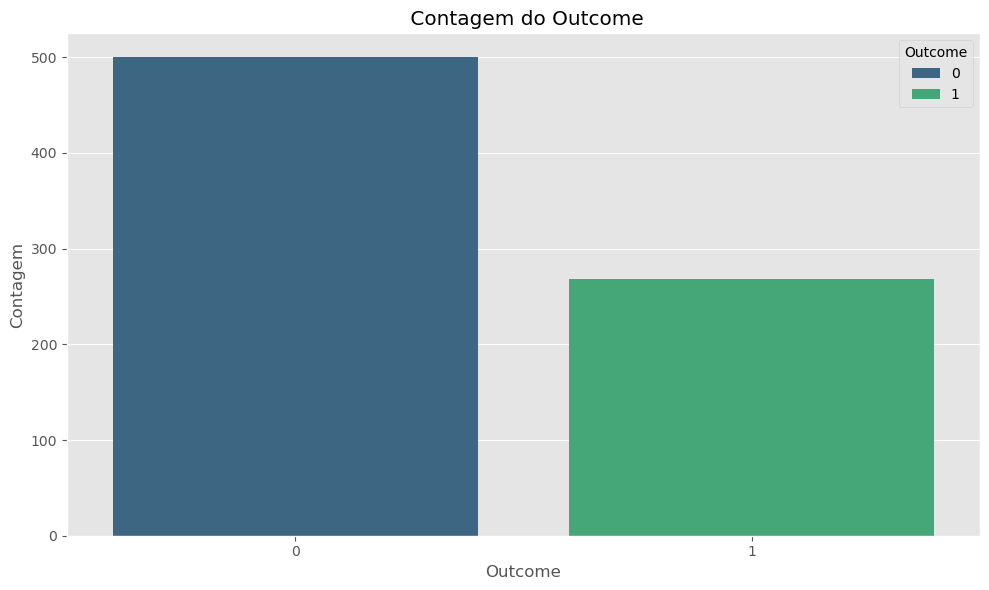

In [12]:
# Gráfico de contagem do Outcome
plt.figure(figsize=(10,6))
sns.countplot(data=diabetes, x="Outcome", hue= "Outcome",palette="viridis")
plt.title(" Contagem do Outcome")
plt.xlabel("Outcome")
plt.ylabel("Contagem")
plt.tight_layout()
plt.show()

In [13]:
diabetes.groupby("Outcome").size()

Outcome
0    500
1    268
dtype: int64

Observando o gráfico de contagem, a variável alvo `Outcome` é desbalanceada, isso quer dizer que há mais representações da classe negativa 0 (não tem diabetes). Essa informação será importante no desenvolvimento dos diferentes modelos de classificação. Quando o dataset for divido em treino/teste, é necessário usar `stratify` para garantir a mesma proporção do outcome de menor número em ambos conjuntos, e posteriormente para escolher métricas adequadas de avaliação do modelo.

---
### Observando as distribuições e medidas estatísticas de cada coluna de diabetes
---

In [14]:
# Criação da função para calcular estatísticas descritivas
def calcular_estatisticas(dataframe, coluna):
    print(f"Estatísticas para a coluna: {coluna}: ")
    estatisticas = dataframe[coluna].agg(["max", "min", "mean", "std"]).round(2)
    display(estatisticas)
    print(f"Moda: {dataframe[coluna].mode()[0]}")
    print(f"Mediana: {dataframe[coluna].median()}")
    print(f"Coeficiente de assimetria: {round(dataframe[coluna].skew(),2)}")
    print(f"Curtose: {round(dataframe[coluna].kurtosis(),2)}")

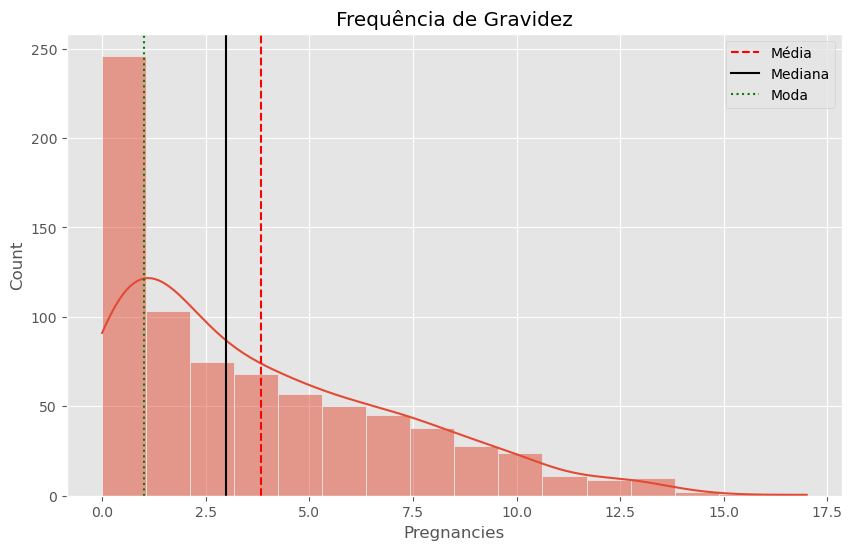

In [15]:
plt.figure(figsize=(10,6))
sns.histplot(data=diabetes, x="Pregnancies", kde=True)
plt.axvline(x=diabetes["Pregnancies"].mean(), color="red", linestyle="--", label= "Média")
plt.axvline(x=diabetes["Pregnancies"].median(), color="black", linestyle="-", label= "Mediana")
plt.axvline(x=diabetes["Pregnancies"].mode()[0], color="green", linestyle=":", label= "Moda")
plt.title("Frequência de Gravidez")
plt.legend()
plt.show()

In [16]:
calcular_estatisticas(diabetes,"Pregnancies")

Estatísticas para a coluna: Pregnancies: 


max     17.00
min      0.00
mean     3.85
std      3.37
Name: Pregnancies, dtype: float64

Moda: 1
Mediana: 3.0
Coeficiente de assimetria: 0.9
Curtose: 0.16


No histograma da frequência de gravidez, pode-se perceber que há uma assimetria à direita, ou seja, o pico da distribuição está à esquerda e a cauda contendo a menor parte dos dados está na direita. O cálculo de skew (assimetria) deixou ainda mais claro como é uma distribuição assimétrica positiva, com o coeficiente de assimetria perto de 1 (0,9).
A curtose positiva e próxima de 0, com o valor de 0,16 (excesso de curtose), evidencia uma curva leptocúrtica, ou seja, os dados estão mais concentrados em torno da média.

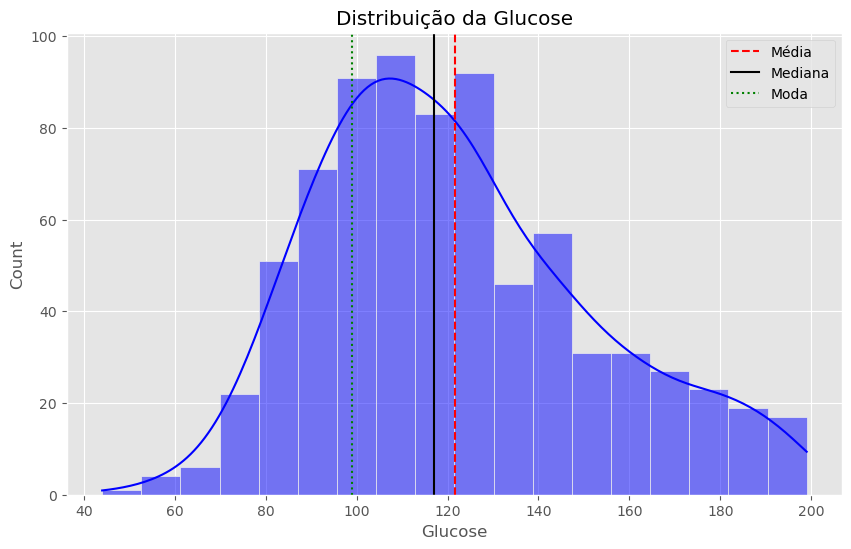

In [17]:
plt.figure(figsize=(10,6))
sns.histplot(data=diabetes, x="Glucose", kde=True, color="blue")
plt.axvline(x=diabetes["Glucose"].mean(), color="red", linestyle="--", label="Média")
plt.axvline(x=diabetes["Glucose"].median(), color="black", linestyle="-", label="Mediana")
plt.axvline(x=diabetes["Glucose"].mode()[0], color="green", linestyle=":", label="Moda")
plt.title("Distribuição da Glucose")
plt.legend()
plt.show()

In [18]:
calcular_estatisticas(diabetes,"Glucose")

Estatísticas para a coluna: Glucose: 


max     199.00
min      44.00
mean    121.66
std      30.44
Name: Glucose, dtype: float64

Moda: 99.0
Mediana: 117.0
Coeficiente de assimetria: 0.54
Curtose: -0.26


 No caso da glucose, podemos ver pela linha KDE que se assemelha há uma distribuição normal, porém analisando o coeficiente de assimetria, o valor positivo acima de 0 indica ser uma distribuição positiva à direita, porém muito próxima de ser uma distribuição normal, visto que o valor é 0.54.

 A curtose menor que 0 (-0.26) mostra uma tendência a curva ser platocúrtica, com dados mais espalhados como podemos ver na linha vermelha do gráfico, porém o valor baixo de assimetria e curtose indicam uma distribuição próxima de ser normal.

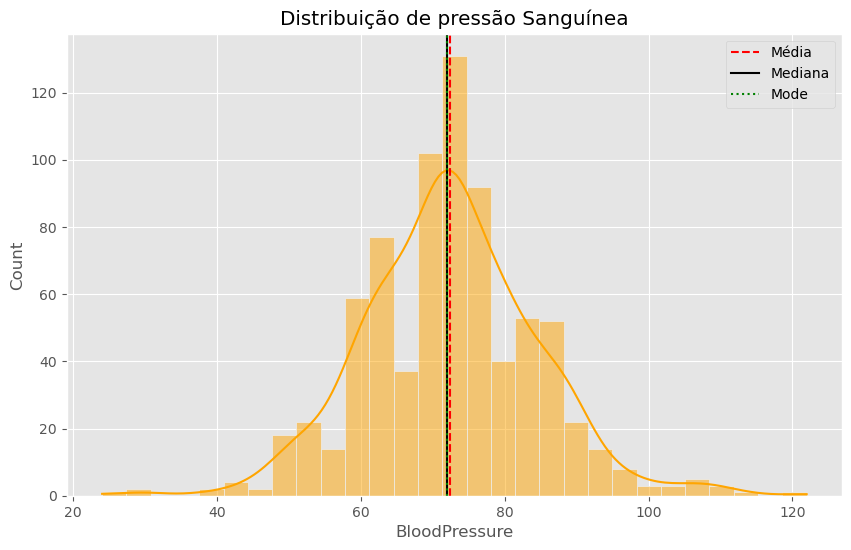

In [19]:
plt.figure(figsize=(10,6))
sns.histplot(data=diabetes, x="BloodPressure", kde=True, color="orange")
plt.axvline(x=diabetes["BloodPressure"].mean(), color="red", linestyle="--", label= "Média")
plt.axvline(x=diabetes["BloodPressure"].median(), color="black", linestyle="-", label="Mediana")
plt.axvline(x=diabetes["BloodPressure"].mode()[0], color="green", linestyle=":", label = "Mode")
plt.title("Distribuição de pressão Sanguínea")
plt.legend()
plt.show()

In [20]:
calcular_estatisticas(diabetes,"BloodPressure")

Estatísticas para a coluna: BloodPressure: 


max     122.00
min      24.00
mean     72.39
std      12.10
Name: BloodPressure, dtype: float64

Moda: 72.0
Mediana: 72.0
Coeficiente de assimetria: 0.14
Curtose: 1.1


Observando o gráfico e olhando os coeficientes de assimetria e curtose, pode-se afirmar que embora se pareça muito com uma distribuição normal, a assimetria pouco maior que 0 (0.14) indica uma tendência a distribuição ser positiva assimétrica à direita e o excesso de curtose de 1.1 mostra que é uma curva leptocútica.
A moda e mediana são exatamente iguais, mas com a média sendo ligeiramente diferente, confirma o que a assimetria e curtose já mostraram, a tendência, mesmo que mínima a assimetria.

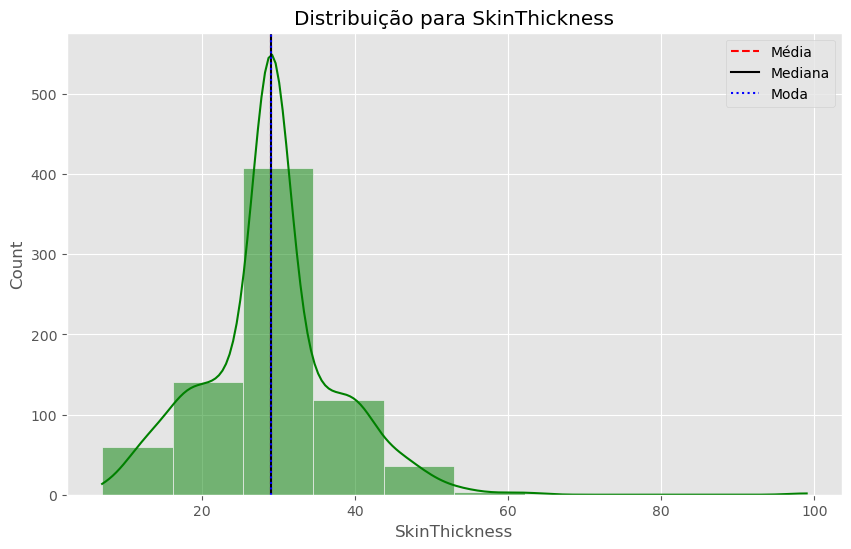

In [21]:
plt.figure(figsize=(10,6))
sns.histplot(data=diabetes, x="SkinThickness", kde=True, color="green", bins=10)
plt.axvline(x=diabetes["SkinThickness"].mean(), color="red", linestyle="--", label="Média")
plt.axvline(x=diabetes["SkinThickness"].median(), color="black", linestyle="-", label="Mediana")
plt.axvline(x=diabetes["SkinThickness"].mode()[0], color="blue", linestyle=":", label="Moda")
plt.title("Distribuição para SkinThickness")
plt.legend()
plt.show()

In [22]:
calcular_estatisticas(diabetes,"SkinThickness")

Estatísticas para a coluna: SkinThickness: 


max     99.00
min      7.00
mean    29.11
std      8.79
Name: SkinThickness, dtype: float64

Moda: 29.0
Mediana: 29.0
Coeficiente de assimetria: 0.84
Curtose: 5.43


Para a distribuição de SkinThickness, o coeficiente de assimetria indica uma distribuição assimétrica positiva à direita (0.84).
E verificando o excesso de curtose (5.43), fica claro que é uma distribuição léptocúrtica, que indica que os dados estão mais concentrados perto da média, o que foi provado analisando as medidas de tendência central quase idênticas.

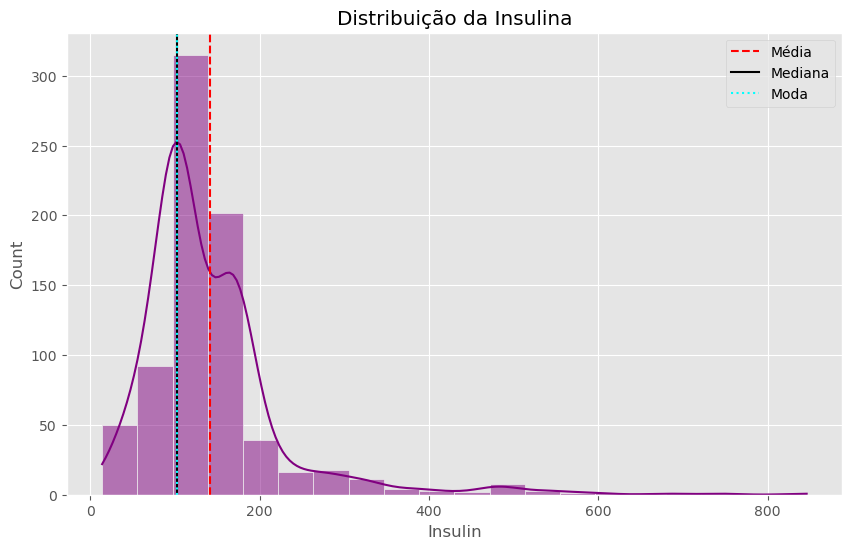

In [23]:
plt.figure(figsize=(10,6))
sns.histplot(data=diabetes, x="Insulin",bins=20, kde=True, color="purple")
plt.axvline(x=diabetes["Insulin"].mean(), color="red", linestyle="--", label="Média")
plt.axvline(x=diabetes["Insulin"].median(), color="black", linestyle="-",label="Mediana")
plt.axvline(x=diabetes["Insulin"].mode()[0], color="cyan", linestyle=":",label="Moda")
plt.legend()
plt.title("Distribuição da Insulina")
plt.show()

In [24]:
calcular_estatisticas(diabetes,"Insulin")

Estatísticas para a coluna: Insulin: 


max     846.00
min      14.00
mean    141.75
std      89.10
Name: Insulin, dtype: float64

Moda: 102.5
Mediana: 102.5
Coeficiente de assimetria: 3.03
Curtose: 13.85


Olhando para o gráfico do nível de insulina e para o coeficiente de assimetria e curtose, ficou evidente que se trata de uma distribuição assimétrica positiva à direita, com uma curva de distribuição leptocúrtica, indicada pelo valor altissímo de curtose de 13,85.

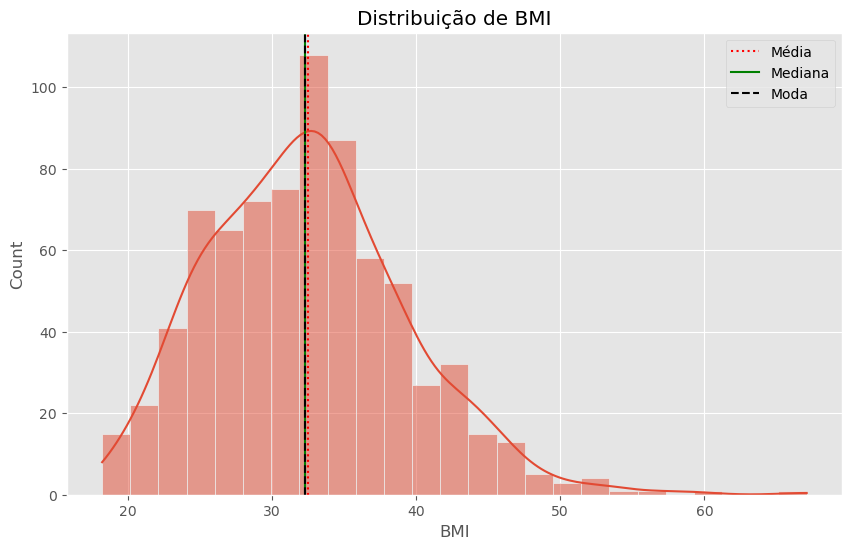

In [25]:
plt.figure(figsize=(10,6))
sns.histplot(data=diabetes, x="BMI", kde=True)
plt.axvline(x=diabetes["BMI"].mean(), color="red", linestyle=":", label="Média")
plt.axvline(x=diabetes["BMI"].median(), color="green", linestyle="-", label="Mediana")
plt.axvline(x=diabetes["BMI"].mode()[0], color="black", linestyle="--", label="Moda")
plt.title("Distribuição de BMI")
plt.legend()
plt.show()

In [26]:
calcular_estatisticas(diabetes,"BMI")

Estatísticas para a coluna: BMI: 


max     67.10
min     18.20
mean    32.46
std      6.88
Name: BMI, dtype: float64

Moda: 32.3
Mediana: 32.3
Coeficiente de assimetria: 0.6
Curtose: 0.92


Para BMI podemos ver uma distribuição assimétrica à direita devido ao coeficiente de assimetria de 0.6. Além disso ela é levemente leptocúrtica (excesso de curtose de 0,92). Olhando as linhas traçadas de média, mediana e moda que são quase idênticas, podemos ver como os dados estão mais próximos da média, mesmo não se tratando de uma distribuição normal.

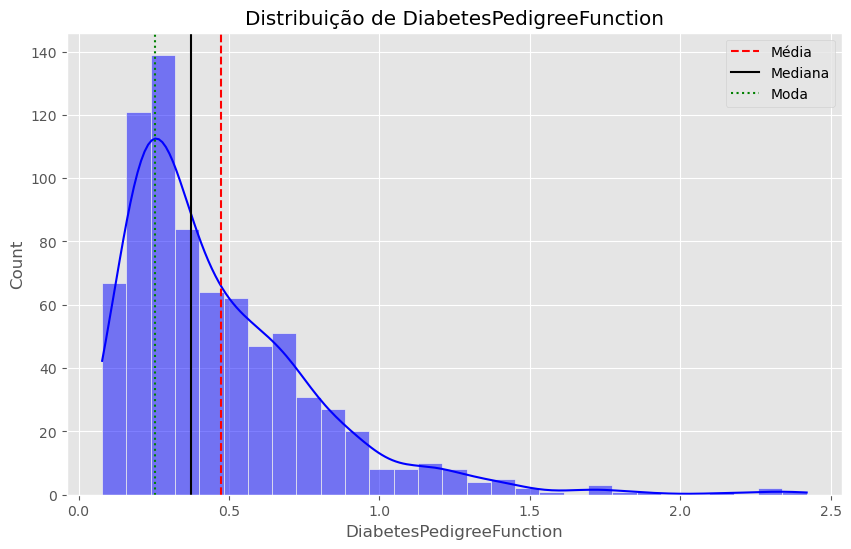

In [27]:
plt.figure(figsize=(10,6))
sns.histplot(data=diabetes, x="DiabetesPedigreeFunction", kde=True, color="blue")
plt.axvline(x=diabetes["DiabetesPedigreeFunction"].mean(), color="red", linestyle="--", label="Média")
plt.axvline(x=diabetes["DiabetesPedigreeFunction"].median(), color="black", linestyle="-", label="Mediana")
plt.axvline(x=diabetes["DiabetesPedigreeFunction"].mode()[0], color="green", linestyle=":", label="Moda")
plt.legend()
plt.title("Distribuição de DiabetesPedigreeFunction")
plt.show()

In [28]:
calcular_estatisticas(diabetes,"DiabetesPedigreeFunction")

Estatísticas para a coluna: DiabetesPedigreeFunction: 


max     2.42
min     0.08
mean    0.47
std     0.33
Name: DiabetesPedigreeFunction, dtype: float64

Moda: 0.254
Mediana: 0.3725
Coeficiente de assimetria: 1.92
Curtose: 5.59


Olhando para a distruição da Diabetes Pedigree Function, que é a medida que quantifica a influência da história familiar da probabilidade de desenvolver a doença, temos uma distribuição assimétrica positiva à direita com uma curva de distribuição leptocútica com nível de assimetria e curtose alto.

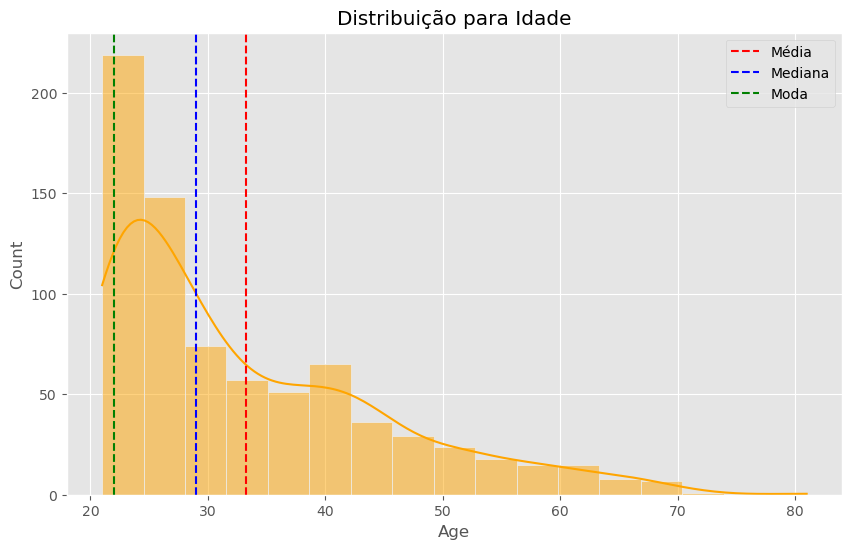

In [29]:
plt.figure(figsize=(10,6))
sns.histplot(data=diabetes, x="Age", kde=True, color="orange")
plt.axvline(x=diabetes["Age"].mean(), color="red", linestyle="--", label="Média")
plt.axvline(x=diabetes["Age"].median(), color="blue", linestyle="--",label="Mediana")
plt.axvline(x=diabetes["Age"].mode()[0], color="green", linestyle="--", label="Moda")
plt.legend()
plt.title("Distribuição para Idade")
plt.show()

In [30]:
calcular_estatisticas(diabetes,"Age")

Estatísticas para a coluna: Age: 


max     81.00
min     21.00
mean    33.24
std     11.76
Name: Age, dtype: float64

Moda: 22
Mediana: 29.0
Coeficiente de assimetria: 1.13
Curtose: 0.64


Para idade (`Age`), temos uma distribuição assimétrica positiva à direita, indicada pela assimetria alta de 1,13 e uma longa cauda à direita após a concentração dos dados, e o excesso de curtose evidencia uma curva leptocútica.


---
### Relação entre BMI e Skin Thickness
---

<Figure size 1000x600 with 0 Axes>

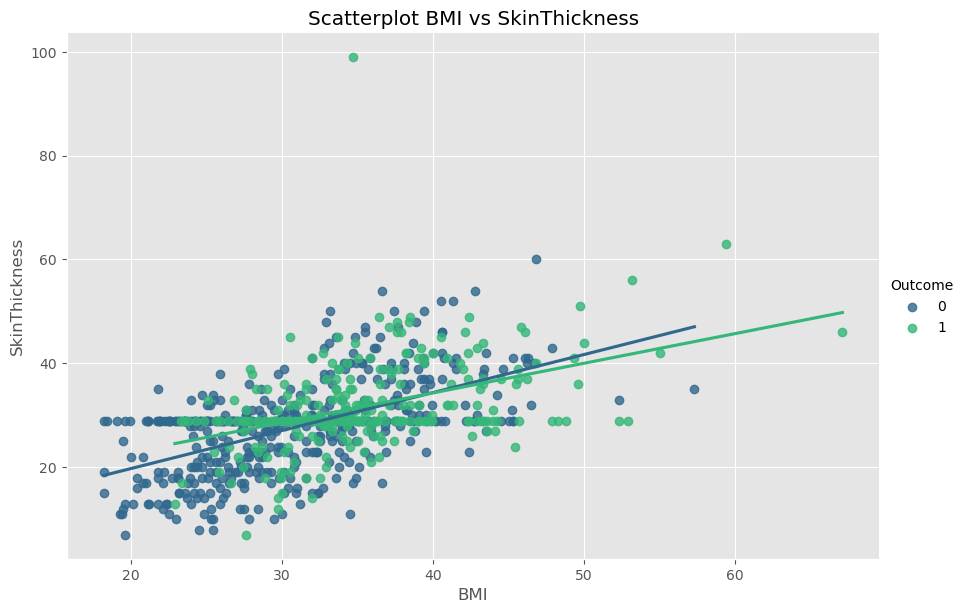

In [31]:
plt.figure(figsize=(10,6))
sns.lmplot(data=diabetes,
            x="BMI", y="SkinThickness", hue="Outcome", 
            palette="viridis", ci=None,
            height=6,
            aspect=1.5,)
plt.title("Scatterplot BMI vs SkinThickness")
plt.show()

Ao observar o gráfico de dispersão que analisa a correlação entre BMI (obsediade) e Skin Thickness (espessura da pele), podemos ver que não há uma correlação clara, porém as diferentes cores para cada outcome mostra uma tendência de que as pessoas com diabetes tendem levemente a ter um BMI e espessura da pele maior que as pessoas que não possuem diabetes. Mas como podemos ver na linha de tendência de ambos outcomes, não há correlação clara. Embora a correlação seja baixa, é possível ver uma separação de classe, os pontos verdes do outcome 1 (possui diabetes) tem uma concentração em uma área superior em relação os pontos azuis que representam quem não têm diabetes, mostrando assim que mesmo com correlação leve, essas variáveis ajudam no diagnóstico da doença, principalmente combinando com outras variáveis.

---
### Boxplots e Violinplots Para Analisar o Impacto de diferentes Variáveis no Outcome
---

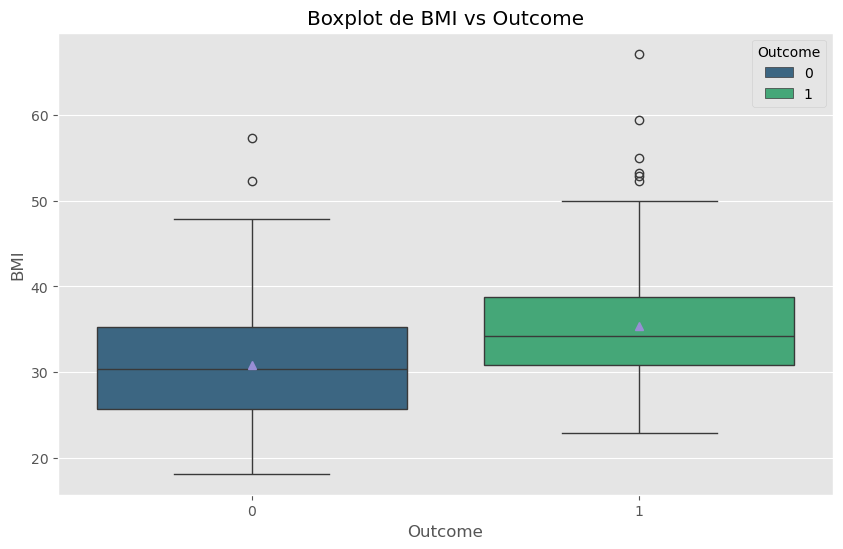

In [32]:
plt.figure(figsize=(10,6))
sns.boxplot(data=diabetes, x="Outcome", y="BMI",showmeans=True, hue= "Outcome", palette="viridis")
plt.title("Boxplot de BMI vs Outcome")
plt.show()

Aprofundando ainda mais na questão de IMC (BMI) e o Outcome, fica ainda mais claro no bloxplot como um indivíduo com um BMI elevado tem uma probabilidade maior de desenvolver diabetes (Outcome=1). Vemos no Outcome positivo vários outliers, mostrando um BMI bem acima do limite máximo. ALém disso, o gráfico mostra que o BMI de 25% dos indivíduos que têm diabetes coresponde a pouco mais de 50% do BMI do grupo que não tem a doença. Isso evidencia a importância do BMI como fator determinante para desenvolver diabetes, porém como mostrado nos outliers para o grupo que não tem a doença, há outros fatores que contribuem para o desenvolvimento de diabetes.

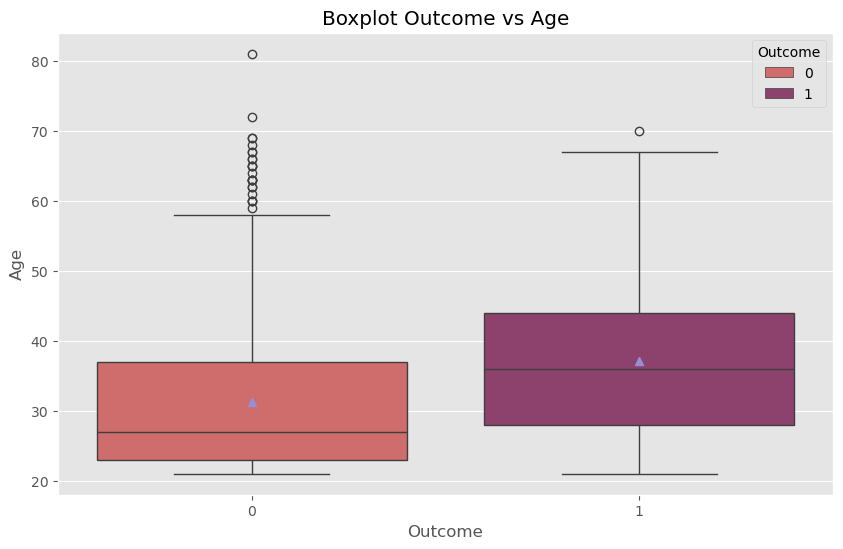

In [33]:
plt.figure(figsize=(10,6))
sns.boxplot(data=diabetes, x="Outcome", y="Age", showmeans=True, palette="flare", hue="Outcome")
plt.title("Boxplot Outcome vs Age")
plt.show()

Observando o boxplot de Outcome vs Age, foi surpreendente observar que há um número maior de outliers relacionado a indivíduos com idade avançada que não têm diabetes (Outcome=0). Olhando para os quartis, podemos ver o Q2(50% dos dados e mediana) do grupo que têm diabtes está perto do Q3 (75%) dos indivíduos que não possuem a doença. Isso deixa claro que pessoas mais velhas têm uma probabilidade maior de desenvolver a doença, possivelmente devido ao declínio de saúde que o envelhecimento causa. Mostrando assim que a idade é um fator importante na causa de diabetes, porém não o único.

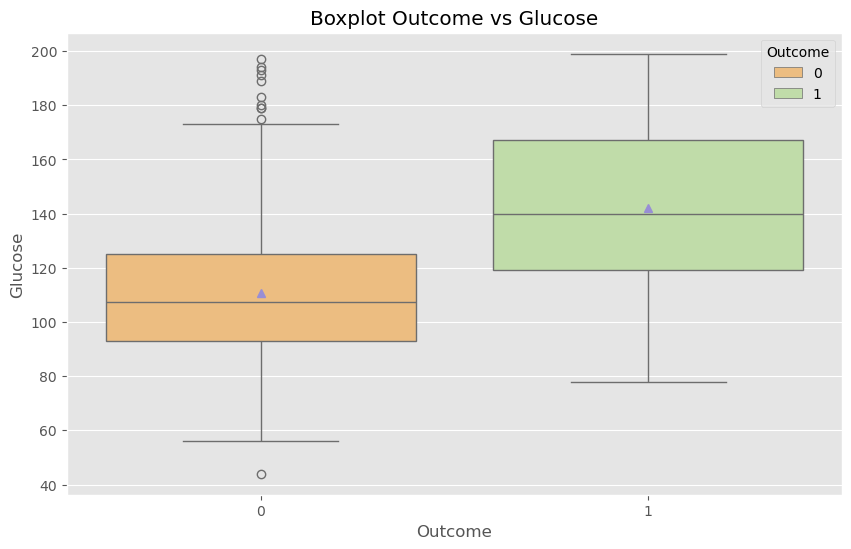

In [34]:
plt.figure(figsize=(10,6))
sns.boxplot(data=diabetes, x="Outcome", y="Glucose", showmeans=True, palette="Spectral", hue="Outcome")
plt.title("Boxplot Outcome vs Glucose")
plt.show()

A glucose alta é um indicador claro de diabetes, o que é evidenciado pelo gráfico com a caixa bem mais elevada para Outcome positivo, mostrando que indivíduos com diabetes têm uma taxa de glucose bem elevada, com o terceiro quartil (Q3) chegando perto do limite máximo do Outcome 0, que não possui diabetes.

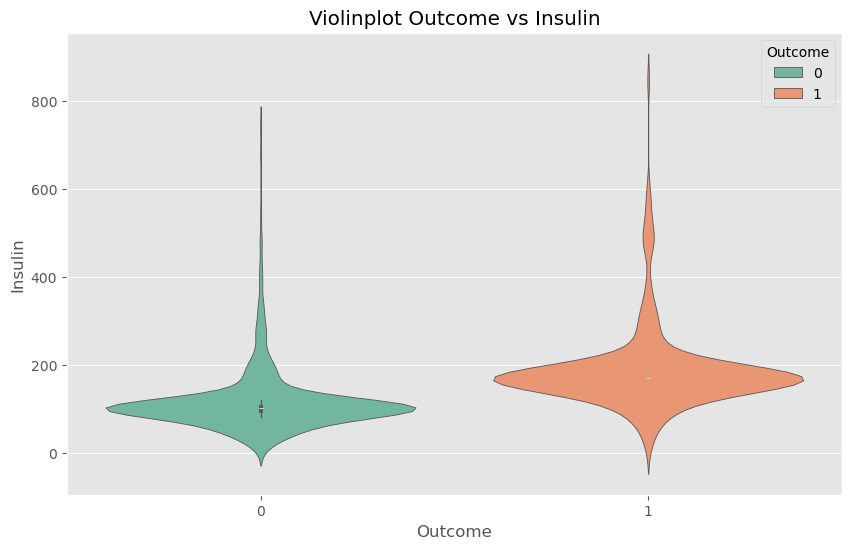

In [35]:
plt.figure(figsize=(10,6))
sns.violinplot(data=diabetes, x="Outcome", y="Insulin", palette="Set2", hue="Outcome")
plt.title("Violinplot Outcome vs Insulin")
plt.show()

O grupo que não tem diabetes possui um nível de insulina mais baixo, como mostrado na área mais densa do gráfico. Já para os indivíduos que possuem a doença, podemos ver que no geral o nível de insulina é maior. Também podemos ver diversos outliers, tanto na parte inferior como na parte superior, com enfâse na cauda superior. Esses valores extremos parecem indicar o tipo de diabetes que a pessoa têm, visto que no tipo 1, a doença se comporta de forma diferente, produzindo menos insulina, enquanto no tipo 2, que parece haver mais ocorrências, o corpo produz mais insulina para compensar a defiência da aceitação de insulina pelo corpo, por isso a cauda superior mais elevada

---
## Matriz de Correlação
---

In [36]:
matriz_corr = diabetes.corr()
display(matriz_corr)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
Pregnancies,1.000000,0.128213,0.208615,0.081770,0.058767,0.021559,-0.033523,0.544341,0.221898
Glucose,0.128213,1.000000,0.218937,0.192615,0.488870,0.231049,0.137327,0.266909,0.492782
BloodPressure,0.208615,0.218937,1.000000,0.191892,0.067036,0.281257,-0.002378,0.324915,0.165723
SkinThickness,0.081770,0.192615,0.191892,1.000000,0.172040,0.543205,0.102188,0.126107,0.214873
Insulin,0.058767,0.488870,0.067036,0.172040,1.000000,0.236674,0.146878,0.123629,0.377081
BMI,0.021559,0.231049,0.281257,0.543205,0.236674,1.000000,0.153438,0.025597,0.312038
DiabetesPedigreeFunction,-0.033523,0.137327,-0.002378,0.102188,0.146878,0.153438,1.000000,0.033561,0.173844
Age,0.544341,0.266909,0.324915,0.126107,0.123629,0.025597,0.033561,1.000000,0.238356
Outcome,0.221898,0.492782,0.165723,0.214873,0.377081,0.312038,0.173844,0.238356,1.000000


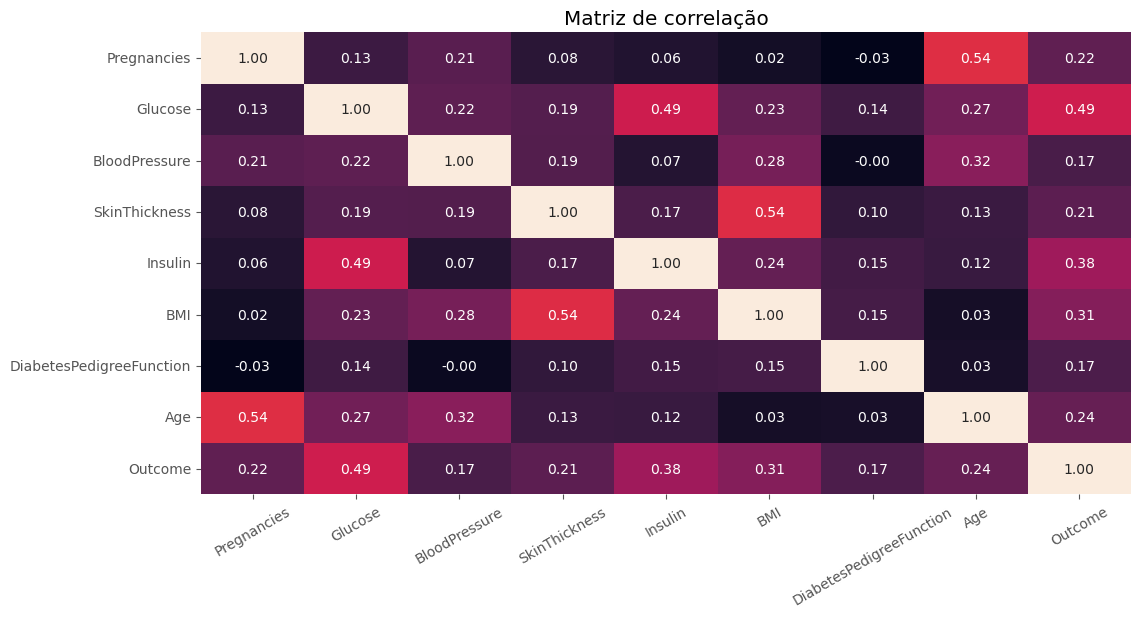

In [37]:
plt.figure(figsize=(12,6))
sns.heatmap(matriz_corr, annot=True, cmap="rocket", fmt=".2f", cbar=False)
plt.title("Matriz de correlação")
plt.xticks(rotation=30)
plt.show()

Observando o heatmap da correlação pude observar de forma mais clara que, apesar de existir uma correlação entre as variáveis, elas não são tão fortes, sendo a maior 0.54, para `SkinThickness` x `BMI` que já foi mostrada acima no gráfico de dispersão. Olhando a matriz de correlação, ficou ainda mais claro que é um conjunto de fatores que influênciam na possibilidade de desenvolver diabetes, não apenas um fator. Agora, olhando para a variável alvo, há três variáveis independentes que possuem uma correlação relevante e podemos dizer que são os fatores que mais influenciam o desenvolvimento de diabetes. A primeira e mais forte correlação é de Glucose com 0,49, essa também foi vista de forma detalhada num boxplot dedicado, Insulin apresentou 0,38 de correlação e BMI 0,31. Também vale a pena mencionar o 0,22 de correlação entre o outcome e Pregnancies (gravidez), há correlação visto que hormônios que aparecem durante a gravidez pode causar a chamda, diabetes gestacional.

---
# Modelos de Classificação
---

---
### Dividindo os dados em treino/teste
---

In [38]:
X = diabetes.drop("Outcome", axis=1)
y = diabetes["Outcome"]

In [39]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25, random_state=16, stratify=y )

Na divisão dos dados de treino e teste, usei o parâmetro `Stratify`. Ele é muito útil para que ambos os datasets mantenham a mesma proporção das classes do dataset original, para que não falte dados de determinada classe para treinar e testar o modelo. Isto é muito importante quando lidamos com datasets desbalanceados, como no caso deste dataset.

---
#### Escalonamento de Features
---

In [40]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

A etapa acima padroniza as features, para garantir que nenhuma variável numérica seja, de maneira errônea mais importante do que outras só por ser um número maior. O `StandardScaler()` garante que isso não aconteça, e para evitar data leakege, usamos o `fit_transform` apenas no dados de treino, e só tranformando com `transform()` os dados de teste, garantindo o vazamento de dados não aconteça. 

O escalonamento de dados, ou padronização é importante para algoritmos como a regressão logística que será implementado e em algoritmos baseados em distância que são mais sensíveis à escala.

---
## Modelo de Regressão Logística
---

In [41]:
from sklearn.linear_model import  LogisticRegression
model = LogisticRegression(random_state=16)
model.fit(X_train_scaled, y_train)


LogisticRegression(random_state=16)

É interessante mencionar que com a padronização das features, o modelo foi construído usando os dados já padronizados, por isso o uso do X_train_scaled em vez do comum Xtrain.
Também é importante o uso do `random_state` que garantirá a reprodutibilidade do código em outros ambientes, evitando que a divisão dos dados de treino e teste sejam diferentes, produzindo assim métricas ligeiramente diferentes.

---
### Testando o Modelo
---

In [42]:
rl_y_pred = model.predict(X_test_scaled)
rl_y_prob = model.predict_proba(X_test_scaled)[:,1]

Na primeira linha o `predict` usa o modelo treinado para fazer previsões e o uso do `predict_proba` extrai a probabilidade da classe positiva (classe 1). O trecho de código [:,1] é usado para selecionar a probabilidade da classe positiva em todas as observações. Como o **predict_proba** retorna uma matriz com a probabilidade de ambas as classes, quando colocamos o **1** depois da vírgula, selecionamos apenas a segunda linha da matriz, com a classe positiva no caso do nosso modelo binário.

---
## Avaliando o Modelo de Regressão Logística
---

In [43]:
import sklearn.metrics as metrics
rl_matriz_conf = metrics.confusion_matrix(y_test, rl_y_pred)
display(rl_matriz_conf)

array([[115,  10],
       [ 29,  38]], dtype=int64)

---
### Matriz de Confusão
---

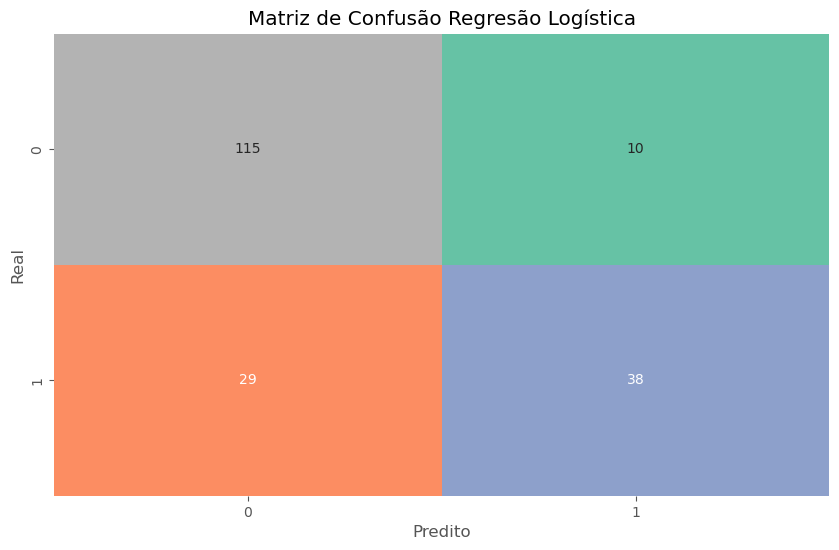

In [44]:
plt.figure(figsize=(10,6))
sns.heatmap(data=rl_matriz_conf, annot=True, cmap="Set2", fmt="g",cbar=False)
plt.title("Matriz de Confusão Regresão Logística")
plt.xlabel("Predito")
plt.ylabel("Real")
plt.show()

Como o modelo criado é uma regressão logística binária, temos apenas duas respostas possíveis, sim (1) ou não (0), tem diabetes ou não tem.

A diagonal principal da matriz de confusão mostra o que o modelo acertou;

As linhas mostram os valores reais;

As colunas os valores previstos.

Assim temos:

- True Negatives: 115 obsersevações foram marcadas corretamente como não tendo diabetes;
- True Positives: 38 observações foram marcadas corretamente como tendo a doença;
- False Positives: 10 observações foram classificadas como tendo diabetes (positivo), quando elas não tinham (negativo);
- False negatives: 29 observações eram classificadas como negativas (não têm diabetes), mas eram positivas (têm diabetes).

--- 
### Métricas do Modelo de Regressão Logística
---

In [45]:
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, roc_curve, auc, log_loss, classification_report
)

def calcular_metricas(y_true, y_pred, y_prob, model_nome):
    print(f"--- Métricas do Modelo de {model_nome} ---")
    print(f"Acurácia: {accuracy_score(y_true, y_pred):.4f}")
    print(f"Acurácia Balanceada: {balanced_accuracy_score(y_true, y_pred):.4f}")
    print(f"Precisão: {precision_score(y_true, y_pred):.4f}")
    print(f"Recall: {recall_score(y_true, y_pred):.4f}")
    print(f"F1 Score: {f1_score(y_true, y_pred):.4f}")
    print(f"ROC AUC: {roc_auc_score(y_true, y_prob):.4f}")
    print(f"Log Loss: {log_loss(y_true, y_prob):.4f}")
    print("\nRelatório de Classificação:")
    print(classification_report(y_true, y_pred))



Esta função foi criada para evitar a repetição de código, visto que será calculado as métricas dos três modelos.

In [46]:
calcular_metricas(y_test, rl_y_pred, rl_y_prob, "Regressão Logística")

--- Métricas do Modelo de Regressão Logística ---
Acurácia: 0.7969
Acurácia Balanceada: 0.7436
Precisão: 0.7917
Recall: 0.5672
F1 Score: 0.6609
ROC AUC: 0.8892
Log Loss: 0.4116

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.80      0.92      0.86       125
           1       0.79      0.57      0.66        67

    accuracy                           0.80       192
   macro avg       0.80      0.74      0.76       192
weighted avg       0.80      0.80      0.79       192



---
### Plotando a Curva ROC do Modelo de Regressão Logística
---

In [47]:
rl_fpr, rl_tpr, rl_thresholds = roc_curve(y_test,rl_y_prob)
rl_auc = auc(rl_fpr, rl_tpr)

O trecho acima calcula o o a taxa de falso positivo e a taxa de verdadeiro positivo da regressão logística, a segunda linha calcula o valor de AUC baseado no resultados da linha acima. 
AUC (Area Under the Curve) calcula a capacidade do modelo para distinguir entre as classes, resumindo o desempenho geral do modelo, variando entre 0 e 1, onde quanto mais perto de 1, melhor é o modelo, e quanto mais perto de 0, pior é o modelo.

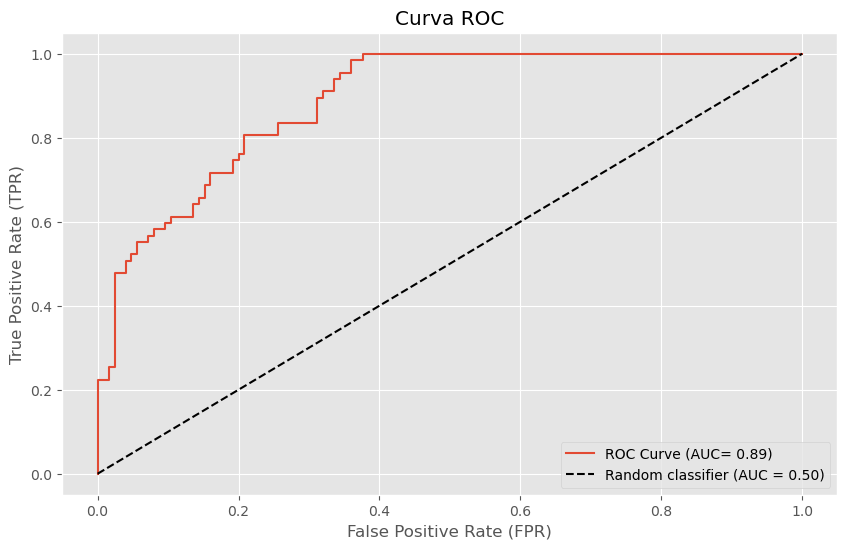

In [48]:
plt.figure(figsize=(10,6))
plt.plot(rl_fpr,rl_tpr, label= f"ROC Curve (AUC= {rl_auc:.2f})")
plt.plot([0,1],[0,1], "k--", label= "Random classifier (AUC = 0.50)")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("Curva ROC")
plt.legend(loc= "lower right")
plt.grid(True)
plt.show()

---
# Impressões do Modelo de Regressão Logística
---

Este modelo é um bom ponto de partida, serviu para analisar os pontos fortes e os pontos fracos.

Para um modelo de classificação de diabetes, vejo com mais preocupações os falsos negativos, pois dizer que alguém não tem diabetes, quando ela tem a doença, pode acarretar em problemas mais sérios, como amputações e morte. Embora um falso positivo cause estresse e gastos, ele é um  pouco menos prejudicial.

Analisando as métricas acima, percebi que pela AUC que o modelo consegue distinguir bem as classes do modelo, com um AUC de 0.89. Já pela curva ROC mostra que apesar de distinguir bem, há margem para melhora, com a curva mais próxima do canto superior esquerdo do que do classificador aleatório, o que é ótimo e nos ajuda ver qual o melhor threshold.
Temos também a acurácia balanceada de 0,74, tem um desempenho pior que a acurácia comum de 79%, indicando dificuldades em prever a classe com menos observações. Um reflexo disso é o recall baixo de 0,57. Isso indica um modelo conservador, que é mais cauteloso em prever a classe positiva, por isso o f1-Score do modelo não é tão baixo (0,66). O log-loss de 0,4116, mostra como o modelo é severamente penalizado pelos erros.


---
# Modelo de Árvore de Decisão
---


In [49]:
from sklearn.tree import DecisionTreeClassifier

dt_model = DecisionTreeClassifier(random_state= 42, max_depth=6)

dt_model.fit(X_train,y_train)

DecisionTreeClassifier(max_depth=6, random_state=42)

Para o modelo de árvore de decisão, além de usar o random_state como na regreessão logística para garantir a reprodutibilidade do código, também é adicionado o `max_depth` que é referente a profundidade da árvore, no caso deste modelo foi estabelecido 6 níveis de split ou divisão na árvore. Além disso o **max_depth** é fundamental para evitar o overfitting, garantindo uma melhor generalização para novos dados de teste e, consequentemente um resultado melhor.

In [50]:
dt_y_pred = dt_model.predict(X_test)
dt_y_proba = dt_model.predict_proba(X_test)[:,1]

---
## Avaliando a Árvore de Decisão
---

In [51]:
dt_cnf_matrix = metrics.confusion_matrix(y_test, dt_y_pred)
display(dt_cnf_matrix)

array([[118,   7],
       [ 10,  57]], dtype=int64)

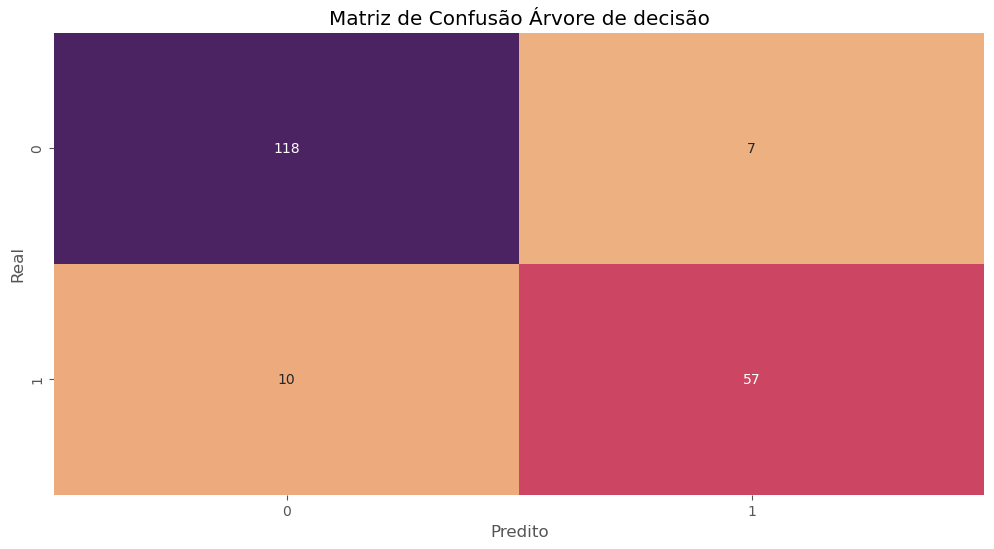

In [52]:
plt.figure(figsize=(12,6))
sns.heatmap(data= dt_cnf_matrix, annot=True, cmap="flare", fmt="g", cbar=False)
plt.title("Matriz de Confusão Árvore de decisão")
plt.xlabel("Predito")
plt.ylabel("Real")
plt.show()

In [53]:
calcular_metricas(y_test, dt_y_pred, dt_y_proba, "Árvore de Decisão")

--- Métricas do Modelo de Árvore de Decisão ---
Acurácia: 0.9115
Acurácia Balanceada: 0.8974
Precisão: 0.8906
Recall: 0.8507
F1 Score: 0.8702
ROC AUC: 0.9607
Log Loss: 0.5533

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.92      0.94      0.93       125
           1       0.89      0.85      0.87        67

    accuracy                           0.91       192
   macro avg       0.91      0.90      0.90       192
weighted avg       0.91      0.91      0.91       192



---
### Calculando a Curva ROC e Construindo o Gráfico Comparando os Dois Modelos
---

In [54]:
dt_fpr, dt_tpr, dt_thresholds = roc_curve(y_test, dt_y_proba)
auc_dt=roc_auc_score(y_test, dt_y_proba)

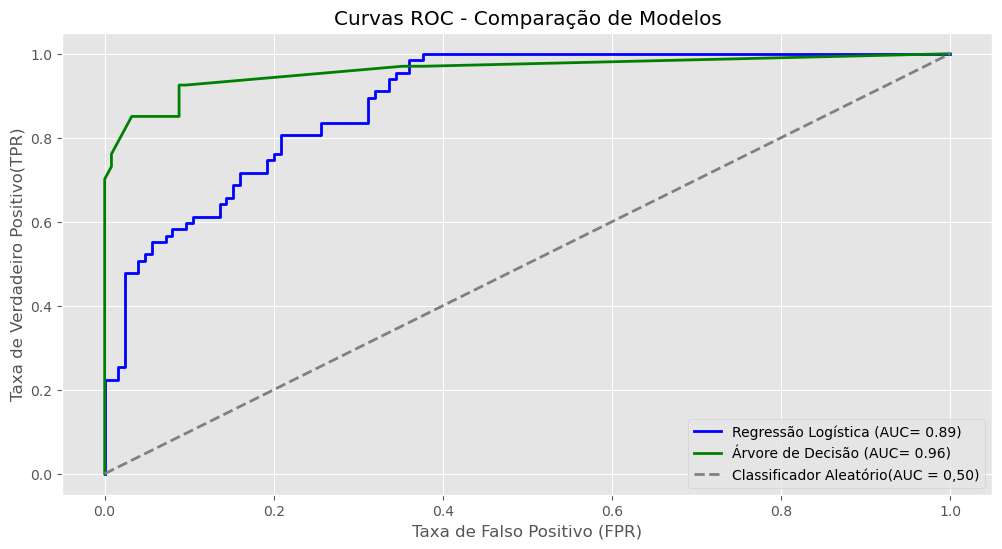

In [55]:
plt.figure(figsize=(12,6))
plt.plot(rl_fpr,rl_tpr,color="blue",lw=2, label= f"Regressão Logística (AUC= {rl_auc:.2f})")
plt.plot(dt_fpr,dt_tpr,color="green",lw=2, label= f"Árvore de Decisão (AUC= {auc_dt:.2f})")

plt.plot([0,1],[0,1],color="gray",lw=2, linestyle="--", label="Classificador Aleatório(AUC = 0,50)")
plt.xlabel("Taxa de Falso Positivo (FPR)")
plt.ylabel("Taxa de Verdadeiro Positivo(TPR)")
plt.title("Curvas ROC - Comparação de Modelos")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

---
# AnalisandoImpressões do Modelo de Árvore de Decisão
---


Após construir a árvore de decisão, achei que o desempenho teve um salto significativo em comparação com o modelo de regressão logística. Olhando para a acurácia balanceada por exemplo, o modelo de regressão logística teve uma acurácia balanceada de 0.79, enquanto a árvore de decisão teve o valor de 0.89. Outro resultado extremamente importante foi o aumento do recall, a árvore de decisão teve um recall de 0.85 contra 0.56 do regressão logística. O impacto desse número é significativo quando olhamos o número de falsos negativos na matriz de confusão. Com a regressão logística tivemos 29 falsos negativos, agora com as árvores de decisão, temos 10 falsos negativos. Uma redução expressiva, consirando o quão importante é diagnosticar corretamente a doença.

O F1-score da árvore de decisão deu um salto em relação a regressão logística, 0.87 contra 0.66, mostrando assim um equilíbrio maior nas classificações do modelo, o que foi evidenciado na matriz de confusão com um número menor de falsos positivos e falsos negativos e o aumento de classificações corretas.

Por último posso destacar o AUC-ROC, na árvore de decisão esse número subiu de 0.88 para 0.96, isso resultou numa curva muito mais perto do eixo superior esquerdo, indicando que o modelo consegue uma boa dintinção entre as classes.

O modelo usando árvores de decisão é demasiadamente superior, comparado ao modelo de regressão logística. Os próximos passos agora será criar e avaliar as métricas de um modelo de Random Forest que é menos propenso a overfitting, o que pode gerar previsões melhores.

---
# Construindo um modelo de Random Forest
---

In [56]:
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(random_state=42, n_estimators=150)
rf_model.fit(X_train,y_train)

RandomForestClassifier(n_estimators=150, random_state=42)

In [57]:
rf_y_pred = rf_model.predict(X_test)
rf_y_proba = rf_model.predict_proba(X_test)[:,1]

---
## Avaliando o Random Forest
---

In [58]:
rf_matrix = metrics.confusion_matrix(y_test, rf_y_pred)
display(rf_matrix)

array([[120,   5],
       [  8,  59]], dtype=int64)

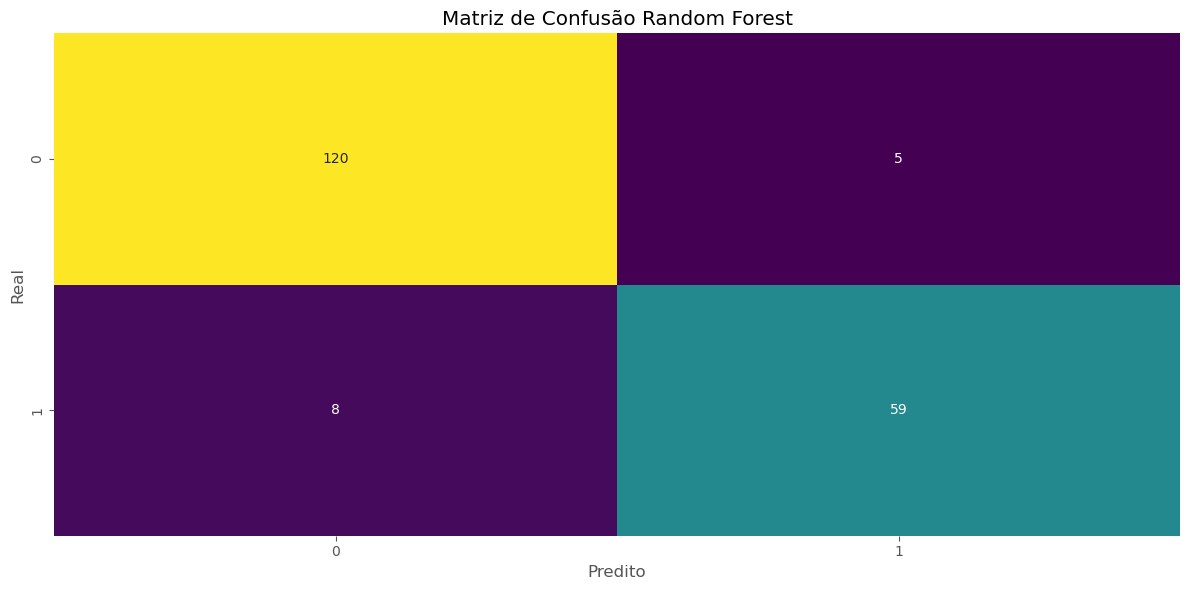

In [59]:
plt.figure(figsize=(12,6))
sns.heatmap(data=rf_matrix, annot= True, cmap="viridis", fmt='g', cbar=False)
plt.title("Matriz de Confusão Random Forest")
plt.xlabel("Predito")
plt.ylabel("Real")
plt.tight_layout()
plt.show()

In [60]:
calcular_metricas(y_test, rf_y_pred, rf_y_proba, "Random Forest")

--- Métricas do Modelo de Random Forest ---
Acurácia: 0.9323
Acurácia Balanceada: 0.9203
Precisão: 0.9219
Recall: 0.8806
F1 Score: 0.9008
ROC AUC: 0.9754
Log Loss: 0.2371

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.94      0.96      0.95       125
           1       0.92      0.88      0.90        67

    accuracy                           0.93       192
   macro avg       0.93      0.92      0.92       192
weighted avg       0.93      0.93      0.93       192



---
### Calculando a Curva ROC e Construindo o Gráfico Comparando os Três Modelos
---

In [61]:
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, rf_y_proba)
rf_auc = auc(fpr_rf, tpr_rf)

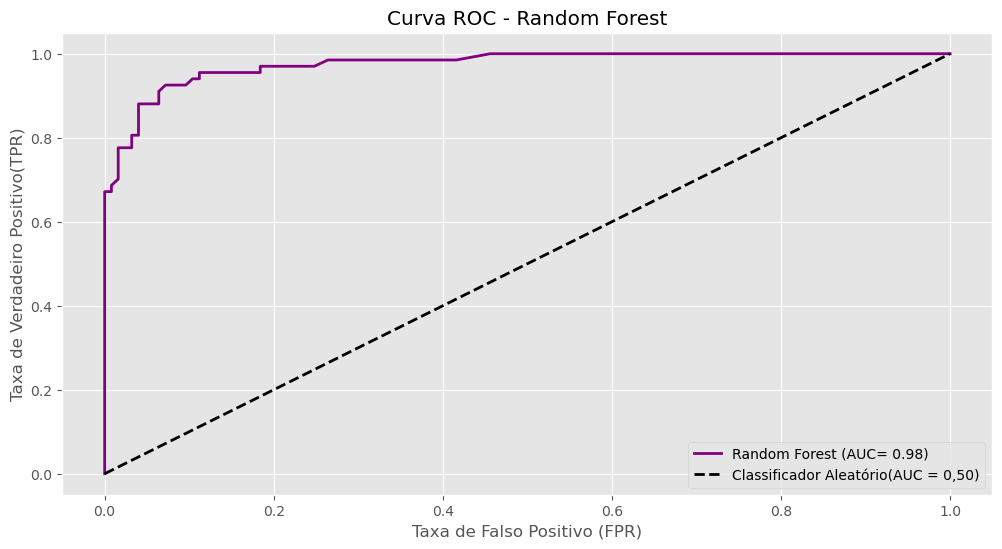

In [65]:
plt.figure(figsize=(12,6))

plt.plot(fpr_rf,tpr_rf, color="purple",lw=2,label= f"Random Forest (AUC= {rf_auc:.2f})")
plt.plot([0,1],[0,1],color="black",lw=2, linestyle="--", label="Classificador Aleatório(AUC = 0,50)")

plt.title("Curva ROC - Random Forest")
plt.xlabel("Taxa de Falso Positivo (FPR)")
plt.ylabel("Taxa de Verdadeiro Positivo(TPR)")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

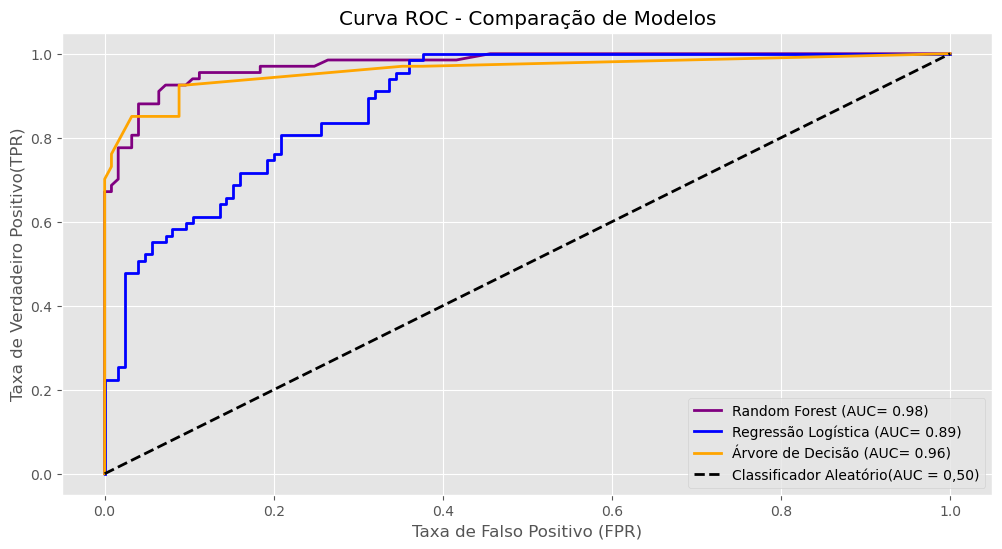

In [66]:
plt.figure(figsize=(12,6))

plt.plot(fpr_rf,tpr_rf, color="purple",lw=2,label= f"Random Forest (AUC= {rf_auc:.2f})")
plt.plot(rl_fpr,rl_tpr,color="blue",lw=2, label= f"Regressão Logística (AUC= {rl_auc:.2f})")
plt.plot(dt_fpr,dt_tpr,color="orange",lw=2, label= f"Árvore de Decisão (AUC= {auc_dt:.2f})")

plt.plot([0,1],[0,1],color="black",lw=2, linestyle="--", label="Classificador Aleatório(AUC = 0,50)")

plt.title("Curva ROC - Comparação de Modelos")
plt.xlabel("Taxa de Falso Positivo (FPR)")
plt.ylabel("Taxa de Verdadeiro Positivo(TPR)")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

---
# Impressões do Modelo de Random Forest
---

Após analisar os três modelos, o que obteve o melhor desempenho foi o algoritmo de Random Forest. Com ele todas as métricas do modelo subiram, e ele conseguiu classificar com mais precisão, conseguindo um bom equilíbrio entre os falsos positivos e os falsos negativos, este que é mais importante para o contexto do problema, teve apenas 8, 2 a menos que o modelo de árvore de decisão e 21 a menos que o modelo de regressão logística.

Olhando a acurácia balanceada do modelo, neste caso uma métrica adequada devido ao desbalanceamento das classes, tivemos um valor de 0,92, oque é um ótimo número que indica que o modelo tem acertado bem para a classe com menos ocorrências.
Outra métrica que representa bem essa redução dos erros de tipo 1 e tipo 2 é o F1-socre de 0,90, um desempenho excelente se comparado os outros dois modelos de classificação testados. O número de falsos positivos (5) e falsos negativos (8), mostram um bom equilíbrio entre precisão e recall.
O ponto de destaque deste modelo foi sem dúvida o AUC-ROC de 0,98, mostrando uma excelente capacidade de separablidade do modelo de random forest, e por ser um modelo ensemble, juntando várias árvores de decisão, quando ele faz a previsão, ele faz com muita certeza, e acerta com muita frequência, o que resulta num log-loss baixo de 0,2371.

O modelo de random forest é o modelo com o melhor desempenho e portanto seria o escolhido para classificar a probabilidade de um índividuo ter diabetes, já que ele faz previsões com mais confiança, tem melhor separabilidade entre as classes e diminuiu muito o erro de tipo II que queremos evitar, os falsos negativos. Para maximizar ainda mais o desempenho do modelo também poderia ser realizado a tunagem dos hiperparâmetros em uma próxima etapa futura. Porém o modelo já apresenta métricas massivamente robustas, mesmo para um modelo inicial e cumpre bem o objetivo, ter o melhor desempenho e o menor número de erros de tipo II.